# Загрузка датасетов + первый взгляд

In [1]:
!mkdir data
!wget https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/hometask/sem10/zhestov.ea%40phystech.edu.csv -O data/zhestov.ea@phystech.edu.csv

--2021-04-19 20:29:28--  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/hometask/sem10/zhestov.ea%40phystech.edu.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125000 (122K) [text/plain]
Saving to: ‘data/zhestov.ea@phystech.edu.csv’

data/zhestov.ea@phy 100%[===================>] 122.07K  --.-KB/s    in 0.02s   

2021-04-19 20:29:29 (4.95 MB/s) - ‘data/zhestov.ea@phystech.edu.csv’ saved [125000/125000]



In [2]:
!pip install sprt

  Created wheel for sprt: filename=sprt-0.0.1-cp37-none-any.whl size=4037 sha256=64d7a5db6210ec34be1dedbecff8481a315acbe3a6d18486e62ae5699f60c42f
  Stored in directory: /root/.cache/pip/wheels/3f/4c/ce/fb40d71e64e7d1aecd9f6a9e1b1b8136d8591d34f8dfee1269
Successfully built sprt


In [3]:
from pandas import read_csv
from sprt import SPRTBinomial
from scipy.optimize import root_scalar
from functools import partial
from numpy import log
from math import floor
from IPython.display import clear_output

In [4]:
df = read_csv('data/zhestov.ea@phystech.edu.csv', header=None)
df.head()

,0
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0


In [5]:
df.describe()

,0
count,5000.000000
mean,0.584200
std,0.492909
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5371d10cd0>]],
      dtype=object)

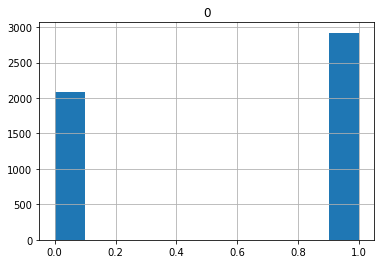

In [6]:
df.hist()

# Задание

## Вопрос 1
Оценка вероятности методом максимального правдоподобия. (Ответ округлите до 3-х знаков после запятой).

In [7]:
p = len(df[df[0] == 1]) / len(df)
print(f'p = {p:.3}')

p = 0.584


## Вопрос 2
С помощью последовательного анализа проверить нулевую гипотезу $p_0=0.5$ против $p_1$, полученной методом максимального правдоподобия. Использовать библиотеку `sprt` с $\alpha=\beta=0.05$. Гипотеза принимается?

Decision:	Reject

      values     lower     upper
n                               
4991  2917.0  2697.968  2715.287
4992  2917.0  2698.511  2715.829
4993  2918.0  2699.053  2716.371
4994  2919.0  2699.595  2716.914
4995  2920.0  2700.138  2717.456
4996  2920.0  2700.680  2717.998
4997  2920.0  2701.222  2718.541
4998  2921.0  2701.765  2719.083
4999  2921.0  2702.307  2719.625
5000     NaN  2702.849  2720.167


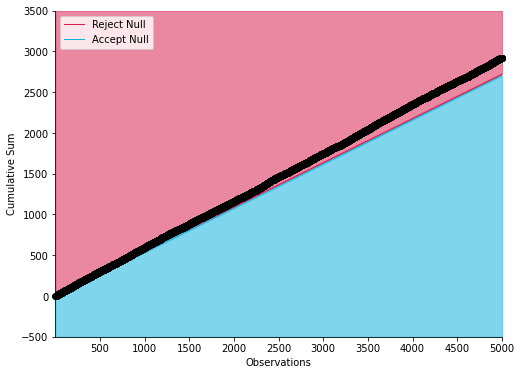

In [8]:
alpha = beta = 0.05

test = SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=df[0])
test.plot()

In [9]:
print(f'We {test.decision.lower()} the null hypothesis')

We reject the null hypothesis


## Вопрос 3
Какое минимальное количество итераций требуется для вынесения решения по данной гипотезе?

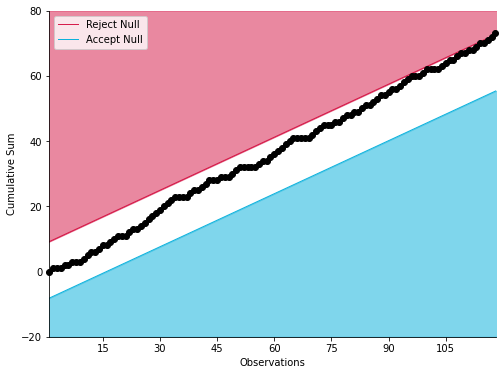


 Гипотеза отклоняется за 119 итераций


In [10]:
i = 50
test = SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=df[0][:i])

while test.decision != 'Reject':
    test = SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=df[0][:i])
    i += 1
# Это сделано чтобы убрать нафиг ненужные таблицы.
clear_output(wait=True)

test.plot()
print(f'\n Гипотеза отклоняется за {i} итераций')

## Вопрос 4
Матождиание требуемого количества итераций (для решения уравнения со слайдов можно использовать `scipy.optimize.root_scalar`). За истинное значение параметра принимать МП-оценку. Округлять до целого числа в меньшую сторону.

Вот до этого момента я вроде понимал, что происходит.


Дальнейший код взят [у Кирилла](https://github.com/puchkovki/psad/blob/master/hometask/sem10/hw-10.ipynb), а он, видимо, чуть доделал [код Андрея](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/seminars/sem10/main.ipynb).

In [11]:
def expectation(p, p_0, alpha, beta, h):
    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    L = (A ** h - 1) / (A ** h - B ** h)
    
    result = (L * log(B) + (1 - L) * log(A)) / (p * log(p / p_0) + (1 - p) * log((1 - p)/(1 - p_0)))
    return result

def f(x, p, p_0):
    return (1 - ((1 - p) / (1 - p_0))**x) / ((p / p_0)**x - ((1 - p) / (1 - p_0))**x) - p

In [12]:
p = len(df[df[0] == 1]) / len(df)
p_0 = 0.5
alpha = 0.05
beta = 0.05

f_new = partial(f, p=p, p_0=p_0)

sol = root_scalar(f_new, bracket=[-10, 10], method='brentq')
print(f'{sol}')
h = sol.root
print(f'\nExpectation of the iterations count: {floor(expectation(p, p_0, alpha, beta, h))}')

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: -1.0000000000000024

Expectation of the iterations count: 186
